In [ ]:
!pip install evaluate

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 84.0/84.0 kB 8.5 MB/s eta 0:00:00


In [ ]:
import pandas as pd
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import re
from datasets import Dataset, DatasetDict
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer, DataCollatorWithPadding
from evaluate import load
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

# Download required NLTK resources
nltk.download('punkt_tab')
nltk.download('stopwords')
nltk.download('wordnet')

# Initialize NLTK components
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

# Define preprocessing functions
def normalize_text(text):
    if not isinstance(text, str) or not text.strip():
        return ""
    text = text.lower()
    text = re.sub(r'[^a-zA-Z\s]', '', text)
    text = re.sub(r'\s+', ' ', text).strip()
    return text

def remove_stopwords(text):
    tokens = word_tokenize(text)
    filtered_tokens = [token for token in tokens if token not in stop_words]
    return ' '.join(filtered_tokens)

def lemmatize_text(text):
    tokens = word_tokenize(text)
    lemmatized_tokens = [lemmatizer.lemmatize(token) for token in tokens]
    return ' '.join(lemmatized_tokens)

# Load CSV files
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

# Apply preprocessing
df_train['Text'] = df_train['Text'].apply(normalize_text).apply(remove_stopwords).apply(lemmatize_text)
df_test['Text'] = df_test['Text'].apply(normalize_text).apply(remove_stopwords).apply(lemmatize_text)

# Convert to Hugging Face Dataset
dataset = DatasetDict({
    "train": Dataset.from_pandas(df_train),
    "test": Dataset.from_pandas(df_test)
})

[nltk_data] Downloading package punkt_tab to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
# Initialize tokenizer
tokenizer = AutoTokenizer.from_pretrained("bert-base-uncased")

# Tokenization function
def tokenize_function(examples):
    return tokenizer(examples["Text"], padding="max_length", truncation=True, max_length=300)

# Apply tokenization
tokenized_datasets = dataset.map(tokenize_function, batched=True)

# Compute class weights
labels = dataset["train"]["Category"]
class_weights = compute_class_weight("balanced", classes=np.unique(labels), y=labels)

# Label mapping
label_mapping = {
    'Accountant': 0, 'Advocate': 1, 'Agriculture': 2, 'Apparel': 3, 'Architecture': 4, 'Arts': 5,
    'Automobile': 6, 'Aviation': 7, 'BPO': 8, 'Banking': 9, 'Blockchain': 10,
    'Building and Construction': 11, 'Business Analyst': 12, 'Civil Engineer': 13,
    'Digital Media': 14, 'DotNet Developer': 15, 'ETL Developer': 16, 'Education': 17,
    'Electrical Engineering': 18, 'Finance': 19, 'Food and Beverages': 20,
    'Health and Fitness': 21, 'Human Resources': 22, 'Information Technology': 23,
    'Java Developer': 24, 'Management': 25, 'Mechanical Engineer': 26,
    'Network Security Engineer': 27, 'Operations Manager': 28, 'PMO': 29, 'Public Relations': 30,
    'Python Developer': 31, 'React Developer': 32, 'SAP Developer': 33, 'SQL Developer': 34,
    'Sales': 35, 'Testing': 36, 'Web Designing': 37, 'Consultant': 38, 'Data Science': 39,
    'Database': 40, 'Designing': 41, 'DevOps': 42
}

# Map string labels to integers
def map_labels(examples):
    examples['label'] = label_mapping[examples['Category']]
    return examples

tokenized_datasets = tokenized_datasets.map(map_labels)

# Initialize model
model = AutoModelForSequenceClassification.from_pretrained("bert-base-uncased", num_labels=43)

# Define training arguments
training_args = TrainingArguments(
    output_dir="./Outputo/results",
    eval_strategy="epoch",
    save_strategy="epoch",
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    learning_rate=5e-5,
    weight_decay=0.01,
    num_train_epochs=6,
    logging_dir="./Outputo/logs",
    logging_steps=100,
    save_total_limit=2,
    fp16=True,
    load_best_model_at_end=True,
    metric_for_best_model="f1",
    greater_is_better=True
)


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/570 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Map:   0%|          | 0/10711 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

Map:   0%|          | 0/10711 [00:00<?, ? examples/s]

Map:   0%|          | 0/2678 [00:00<?, ? examples/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/440M [00:00<?, ?B/s]

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Load metrics
accuracy_metric = load("accuracy")
precision_metric = load("precision")
recall_metric = load("recall")
f1_metric = load("f1")

# Define compute_metrics function
def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predictions = logits.argmax(axis=-1)
    metrics = {
        "accuracy": accuracy_metric.compute(predictions=predictions, references=labels)["accuracy"],
        "precision": precision_metric.compute(predictions=predictions, references=labels, average="weighted")["precision"],
        "recall": recall_metric.compute(predictions=predictions, references=labels, average="weighted")["recall"],
        "f1": f1_metric.compute(predictions=predictions, references=labels, average="weighted")["f1"]
    }
    return metrics

# Data collator
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

# Custom Trainer to handle class weights
class CustomTrainer(Trainer):
    def compute_loss(self, model, inputs, return_outputs=False, num_items_in_batch=None):
        labels = inputs.get("labels")
        outputs = model(**inputs)
        logits = outputs.get("logits")
        class_weights_tensor = torch.tensor(class_weights, dtype=torch.float32, device=logits.device)
        loss_fct = nn.CrossEntropyLoss(weight=class_weights_tensor)
        loss = loss_fct(logits.view(-1, self.model.config.num_labels), labels.view(-1))
        return (loss, outputs) if return_outputs else loss

# Initialize CustomTrainer
trainer = CustomTrainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["test"],
    processing_class=tokenizer,
    data_collator=data_collator,
    compute_metrics=compute_metrics
)

# Train the model
trainer.train()


wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.


<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: coder2675 (coder2675-iit-bombay) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


Epoch,Training Loss,Validation Loss,Accuracy,Precision,Recall,F1
1,1.298000,0.991200,0.786408,0.780867,0.786408,0.767417
2,0.648900,0.608432,0.867438,0.871711,0.867438,0.866476
3,0.532600,0.590475,0.868932,0.870861,0.868932,0.867447
4,0.344700,0.593441,0.882001,0.886179,0.882001,0.881961
5,0.279400,0.567028,0.892084,0.894246,0.892084,0.891678
6,0.161800,0.559886,0.888723,0.893956,0.888723,0.889340


/usr/local/lib/python3.11/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


TrainOutput(global_step=4020, training_loss=0.7202176986049064, metrics={'train_runtime': 1128.5411, 'train_samples_per_second': 56.946, 'train_steps_per_second': 3.562, 'total_flos': 9911320137529200.0, 'train_loss': 0.7202176986049064, 'epoch': 6.0})

In [ ]:
# Evaluate the model
eval_results = trainer.evaluate()
print("Evaluation Results:", eval_results)

# Save the model and tokenizer
trainer.save_model("./Outputo/final_model")
tokenizer.save_pretrained("./Outputo/final_model")

Evaluation Results: {'eval_loss': 0.5670278072357178, 'eval_accuracy': 0.892083644510829, 'eval_precision': 0.8942458949406488, 'eval_recall': 0.892083644510829, 'eval_f1': 0.8916781289009194, 'eval_runtime': 11.3712, 'eval_samples_per_second': 235.508, 'eval_steps_per_second': 14.774, 'epoch': 6.0}


('./Outputo/final_model/tokenizer_config.json',
 './Outputo/final_model/special_tokens_map.json',
 './Outputo/final_model/vocab.txt',
 './Outputo/final_model/added_tokens.json',
 './Outputo/final_model/tokenizer.json')

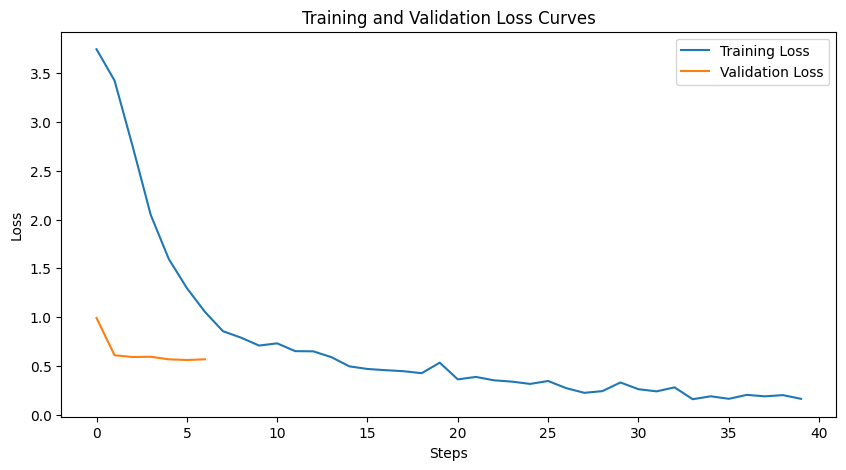

In [ ]:
# Plot training and validation loss curves
log_history = trainer.state.log_history
train_loss = [log["loss"] for log in log_history if "loss" in log]
eval_loss = [log["eval_loss"] for log in log_history if "eval_loss" in log]
steps = range(len(train_loss))

plt.figure(figsize=(10, 5))
plt.plot(steps, train_loss, label="Training Loss")
plt.plot(steps[:len(eval_loss)], eval_loss, label="Validation Loss")
plt.xlabel("Steps")
plt.ylabel("Loss")
plt.title("Training and Validation Loss Curves")
plt.legend()
plt.savefig('loss_curves.png')
plt.show()

In [ ]:
# 1. Zip the folder
!zip -r Outputo.zip Outputo
# 2. Download the zipped folder
from google.colab import files
files.download('Outputo.zip')


# New Section